# StaTexNet - Network Encoding Statistics for Textures

## Dependencies & Hyperparameters

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
import numpy as np

import utils.statnetencoder as sne
import imp

#import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch

#use GPU 2
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

#data parameters
batch_size = 8
crop_size = 128

#dataset location
dtd_folder = '~/data/dtd/'

## Define DataLoader

In [2]:
loading_transforms = torchvision.transforms.Compose([#transforms.CenterCrop(size=300),
                                                    #transforms.RandomRotation(degrees=180),
                                                    transforms.Grayscale(),
                                                    transforms.TenCrop(size=crop_size),
                                                    #transforms.functional.vflip(),
                                                    #transforms.functional.hflip(),
                                                    transforms.Lambda(lambda crops: torch.stack([transforms.PILToTensor()(crop) for crop in crops])),
                                                    transforms.ConvertImageDtype(torch.float32)])
                                                    #transforms.PILToTensor()])
    
#cropping_transforms = torchvision.transforms.Compose([#transforms.CenterCrop(size=crop_size),
#                                                        transforms.TenCrop(size=crop_size),
#                                                        transforms.Lambda(lambda crops: torch.stack([transforms.PILToTensor()(crop) for crop in crops])),
#                                                        #transforms.ToTensor()
#                                                        ])

#use training set for now
dtd_dataset = torchvision.datasets.DTD(root='~/data/dtd_torch', split='train', partition=1, 
                                       transform=loading_transforms, target_transform=None,
                                       download=True)

sampler = data.RandomSampler(dtd_dataset)

dtd_dataloader = DataLoader(dtd_dataset, 
                            sampler=sampler,
                            batch_size=batch_size, 
                            shuffle=False)

tensor2pil_transform = transforms.ToPILImage()

## Test Dataloader

torch.Size([8, 10, 1, 128, 128])


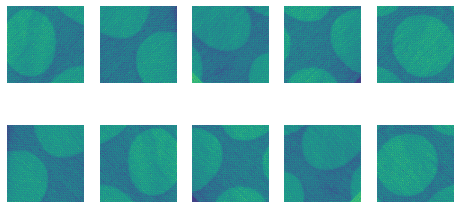

torch.Size([8, 10, 1, 128, 128])


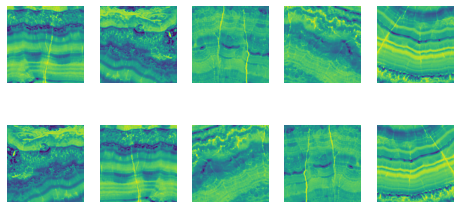

torch.Size([8, 10, 1, 128, 128])


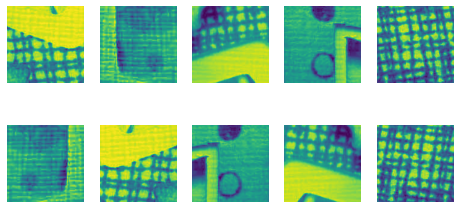

torch.Size([8, 10, 1, 128, 128])


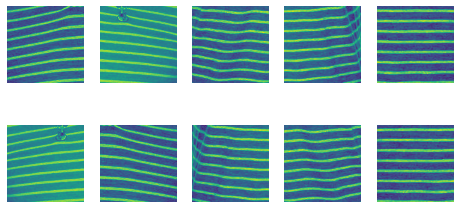

In [3]:
for j, texture_batch in enumerate(dtd_dataloader):
    #texture_batch = cropping_transforms(texture_batch[0])
    #print(len(texture_batch))
    output = texture_batch[0].to(device)
    #output = texture_batch[0][np.r_[1:6,7:-1]].to(device)
    #print(output)
    print(output.shape)
    plt.figure(figsize=(8,4))
    for i in range(10):
        plt.subplot(2,5,i+1)
        # first index 
        plt.imshow(tensor2pil_transform(output[j,i,:,:,:]))
        plt.axis('off')
    plt.show()
    if(j==3):
        break;
    
#tensor2pil_transform(output[4,0,:,:,:])

## Build Batched Pyramids

In [19]:
testims.shape

torch.Size([10, 1, 128, 128])

In [34]:
#test
#testims = torch.from_numpy(np.zeros((9,1,256,256),dtype=np.float32)).to(device)
testims = output[1]

pyr = SCFpyr_PyTorch(height=5, nbands=4, scale_factor=2, device=device)
pyr_coeffs = pyr.build(testims)

height of pyramid is, 5


## Visualize a Single Pyramid

(4, 512, 512)
torch.Size([4, 1, 512, 512])
height of pyramid is, 5


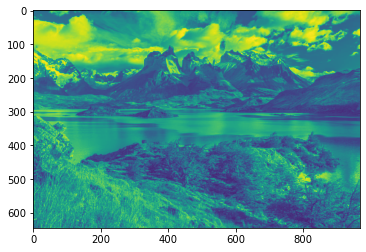

In [65]:
import cv2
image = cv2.imread('./assets/patagonia.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
image = image[:512,:512]
image = np.repeat(image[np.newaxis,:,:],4,axis=0)
print(image.shape)
img = torch.from_numpy(image.astype(np.float32)).to(device)
img = torch.unsqueeze(img,dim=1)
print(img.shape)
#image = cv2.resize(image, dsize=(128,128))
pyr_coeffs = pyr.build(img)

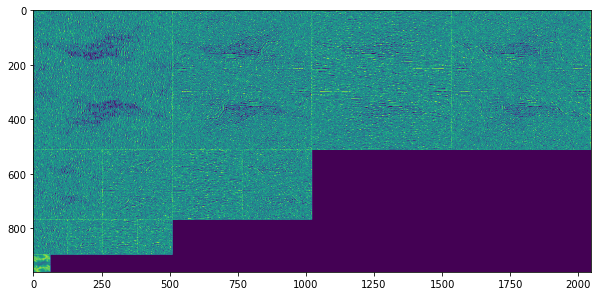

In [66]:
#Pull a Single Pyramid
#single_pyr_coeff = pyr_coeffs
single_pyr_coeff = utils.extract_from_batch(pyr_coeffs)
img = utils.make_grid_coeff(single_pyr_coeff,normalize=True)
plt.figure(figsize=(10,20))
plt.imshow(img)

In [67]:
print(f'High Pass Filter has shape {pyr_coeffs[0].shape}')
print(f'Low Pass Filter has shape {pyr_coeffs[-1].shape}')
for i in range(1,len(pyr_coeffs)-1):
    print(f'Level {i} has {len(pyr_coeffs[i])} orientations of shape {pyr_coeffs[i][0].shape}')

High Pass Filter has shape torch.Size([4, 512, 512])
Low Pass Filter has shape torch.Size([4, 64, 64])
Level 1 has 4 orientations of shape torch.Size([4, 512, 512, 2])
Level 2 has 4 orientations of shape torch.Size([4, 256, 256, 2])
Level 3 has 4 orientations of shape torch.Size([4, 128, 128, 2])


## Test Pyramid Vectorization

In [72]:
vectorized_pyramid = utils.vectorize_batch(pyr_coeffs)
vtotal = vectorized_pyramid.shape[0] * vectorized_pyramid.shape[1]
print(f'Size of Vectorized Pyramid is {vtotal}')

total = pyr_coeffs[0].flatten().shape[0]+pyr_coeffs[-1].flatten().shape[0]
for i in range(1,len(pyr_coeffs)-1):
    for o in pyr_coeffs[i]:
        total += o.flatten().shape[0]

print(f'Manually Calculated Size is {total}')

Size of Vectorized Pyramid is 12075008
Manually Calculated Size is 12075008


## Test Henaff Pyramid Code

In [5]:
import numpy as np
test = np.zeros((100,100,100,100))
fft = np.fft.rfftn(test,axes=[3,2])
print(test.shape, fft.shape)

(100, 100, 100, 100) (100, 100, 51, 100)


In [8]:
import torch
device = torch.device('cuda:1')
imgSize=128
x = torch.randn((1,imgSize,imgSize,imgSize),requires_grad=True, device=device)    

In [20]:
fftfull = torch.fft.rfft2(x)
print(x.shape, fftfull.shape)

torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 65])


In [1]:
import sys
sys.path.append("../steerablePyramid")
#import config as config
#import steerableUtils
import steerablePyr as sp

x torch.Size([1, 1, 128, 128])
fftfullshape torch.Size([1, 1, 128, 128])
x torch.Size([1, 2, 1, 1, 128, 128])
torch.Size([1, 1, 1, 2, 128, 128]) torch.Size([1, 2, 1, 1, 128, 128])
n torch.Size([1, 1, 5, 128, 128, 2])
npost torch.Size([1, 1, 5, 128, 128])
n torch.Size([1, 1, 4, 64, 65, 2])
npost torch.Size([1, 1, 4, 64, 65])
n torch.Size([1, 1, 4, 32, 33, 2])
npost torch.Size([1, 1, 4, 32, 33])
n torch.Size([1, 1, 4, 16, 17, 2])
npost torch.Size([1, 1, 4, 16, 17])
n torch.Size([1, 1, 1, 8, 9, 2])
npost torch.Size([1, 1, 1, 8, 9])

input size
torch.Size([1, 1, 128, 128])

output size
0 torch.Size([1, 1, 1, 128, 128])
1 torch.Size([1, 1, 4, 128, 128])
2 torch.Size([1, 1, 4, 64, 65])
3 torch.Size([1, 1, 4, 32, 33])
4 torch.Size([1, 1, 4, 16, 17])
5 torch.Size([1, 1, 1, 8, 9])

reconstruction size
torch.Size([1, 1, 128, 128])

reconstruction error tensor(23.7993, device='cuda:0')


/data/scratch/vasha/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [3]:
mypyr = sp.SteerablePyramid(128)

In [4]:
mypyr.K

4

In [5]:
mypyr.l[3].shape

torch.Size([1, 1, 1, 1, 8, 5])